# Emotional classification through voice using Backpropagation

## Topic

In this notebook I experienced with audio classification, the dataset has 1400 audios of spoken sentences in each of the 7 emotional states (happy, angry, pleasant, disgust, sad, neutral and fear). My goal is to preprocess the raw audio into a form that a neural network can learn from, for that I used Melspectrograms, and them build a model that can accurately classify a voice tone as being in one of the mentioned class. 

## Objective

- Process raw audio data to be neural net ready
- Build a classififer that can tell the emotion in a voice

## Summary

- Importing libraries
- Extracting audio files
- Extracting Mel Spectrograms
- Audio transformation
- Creating the target dataset
- Train/Test split
- Creating the data loaders
- Building the Classifier
- Training and inference
- Trying out the model
- Conclusion

### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import numpy as np 
import torch
import torchaudio
from torch import nn
from torch import optim
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from IPython.display import Audio
import IPython.display as ipd
from glob import glob
import librosa

### Extracting the audio files

In [2]:
audio_files = glob(r"C:\Users\imane\Downloads\archive (14)\Emotional speech set data\Emotional speech set data\*\*.wav")

In [3]:
ipd.Audio(audio_files[1])

In [4]:
ipd.Audio(audio_files[201])

In [5]:
ipd.Audio(audio_files[856])

In the above I extracted the audio files paths using glob and played some audios with the help of IPython display.

In [6]:
soundwave, sample_rate = torchaudio.load(audio_files[1])
print(soundwave.shape)
print(sample_rate)

torch.Size([1, 51542])
24414


<Axes: >

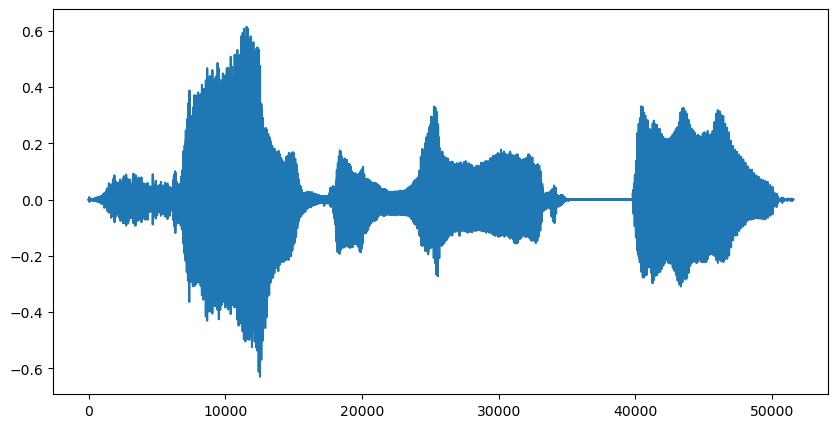

In [7]:
soundwave = torch.flatten(soundwave)
pd.Series(soundwave).plot(figsize=(10,5))

In [8]:
soundwave, sample_rate = torchaudio.load(audio_files[201])
print(soundwave.shape)
print(sample_rate)

torch.Size([1, 65961])
24414


<Axes: >

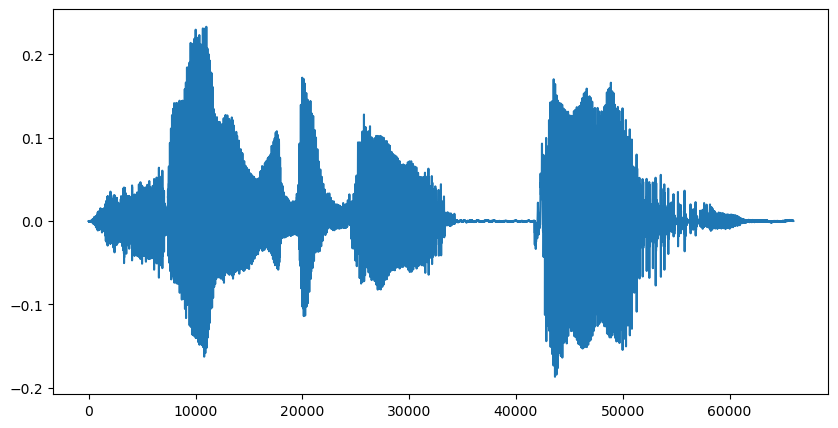

In [9]:
soundwave = torch.flatten(soundwave)
pd.Series(soundwave).plot(figsize=(10,5))

In [10]:
soundwave, sample_rate = torchaudio.load(audio_files[856])
print(soundwave.shape)
print(sample_rate)

torch.Size([1, 49318])
24414


<Axes: >

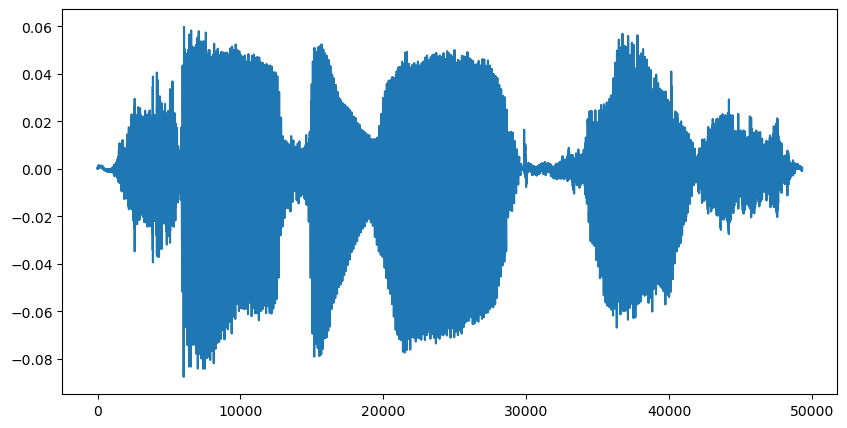

In [11]:
soundwave = torch.flatten(soundwave)
pd.Series(soundwave).plot(figsize=(10,5))

In the above I loaded some example files with torchaudio and ploted their waveforms. The waveform gives us information about the time and amplitude(loudness) of the samples but not the change in frequencies (which I will use a spectrogram for).

### Extracting Mel spectrograms

In [12]:
soundwave, sample_rate = librosa.load(audio_files[1])
mel = librosa.feature.melspectrogram(y = soundwave, sr = sample_rate, n_mels = 128)
db = librosa.amplitude_to_db(np.abs(mel), ref=np.max)

In [13]:
db.shape

(128, 91)

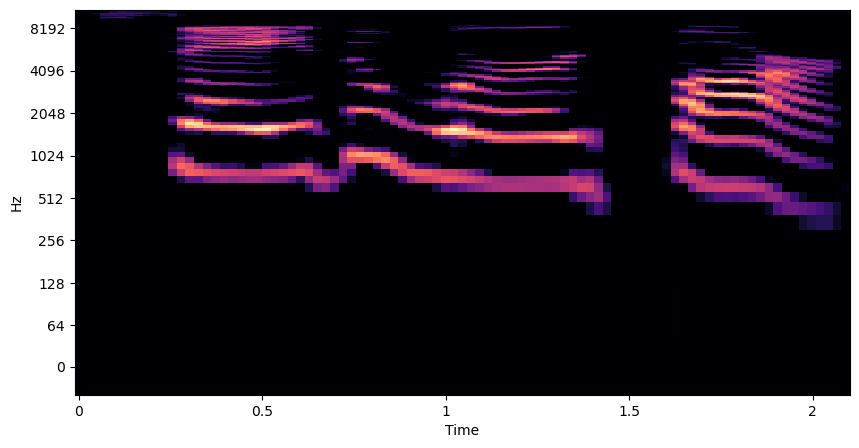

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(db, x_axis = "time", y_axis ='log',
                              ax = ax)

In [15]:
soundwave, sample_rate = librosa.load(audio_files[201])
mel = librosa.feature.melspectrogram(y = soundwave, sr = sample_rate, n_mels = 128)
db = librosa.amplitude_to_db(np.abs(mel), ref=np.max)
db.shape

(128, 117)

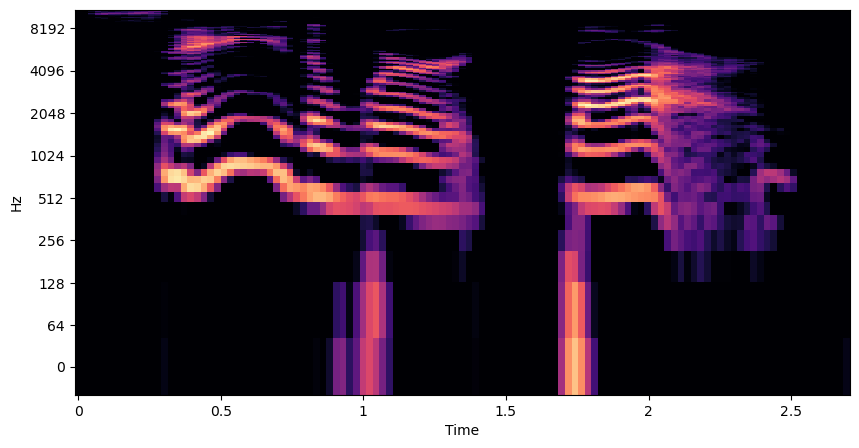

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(db, x_axis = "time", y_axis ='log',
                              ax = ax)

In [17]:
soundwave, sample_rate = librosa.load(audio_files[856])
mel = librosa.feature.melspectrogram(y = soundwave, sr = sample_rate, n_mels = 128)
db = librosa.amplitude_to_db(np.abs(mel), ref=np.max)
db.shape

(128, 87)

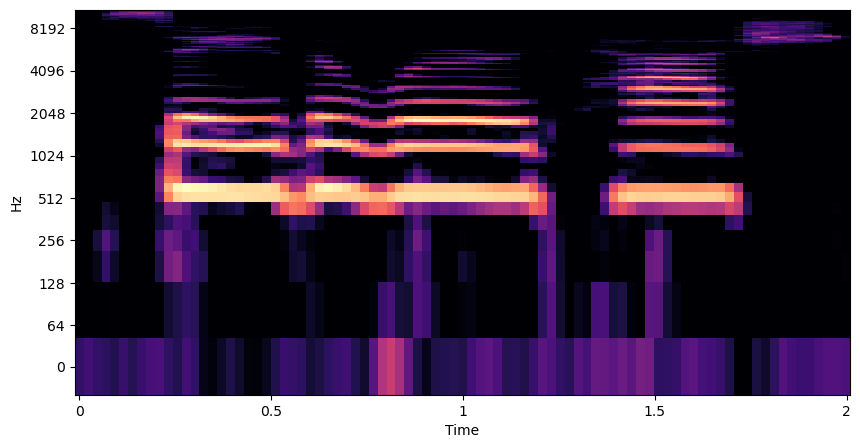

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(db, x_axis = "time", y_axis ='log',
                              ax = ax)

With the help of librosa I was able to extract mel spectrograms of some audios to see the changes in audio frequencies as it is heard by the human ear. I converted my waveforms to mel spectrograms which convert the frequencies to mel scales  and then to decibels to see the changes in amplitude.

### Audio transformation

In [19]:
soundwaves, sample_rates = [], []
for i in range(len(audio_files)):
    soundwave, sample_rate = torchaudio.load(audio_files[i], normalize = True)
    soundwave = torch.flatten(soundwave)
    resample = torchaudio.transforms.Resample(int(sample_rate), int(sample_rate/10))
    soundwave = resample(soundwave)
    mel = torchaudio.transforms.MelSpectrogram(int(sample_rate/10), n_mels=64, n_fft=1024, hop_length=None)
    soundwave = mel(soundwave)
    db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
    soundwave = db(soundwave)
    soundwaves.append(soundwave)
    sample_rates.append(int(sample_rate/10))

In [20]:
soundwaves[48].shape 

torch.Size([64, 12])

In [21]:
soundwaves[86].shape

torch.Size([64, 10])

In [22]:
m = []
for i in range(len(soundwaves)):    
    m.append(soundwaves[i].shape[1]) 
print(max(m))

14


In [23]:
target_len = 14
for i in range(len(soundwaves)):
    soundwaves[i] = F.pad(soundwaves[i], (target_len - soundwaves[i].size(1), 0))

In [24]:
soundwaves[12].shape

torch.Size([64, 14])

In [25]:
soundwaves[36].shape

torch.Size([64, 14])

In [26]:
sw = []
for tensor in soundwaves:
    a = torch.flatten(tensor)
    sw.append(a)

In the above I transformed the entire dataset to be ready for the network. The first thing I did is resample to reduce the size of my data, the original sample rate was 24414Hz and I set it to be 24414/10Hz. Then I extracted the mel spectrograms with 64 mels and converted to decibels and stored everything in lists. Seen as the shapes of the matrices that resulted were different, I had to pad them to be of the same shape and flattened them to get the number of input neurons for the following network.

### Creating the target dataset

In [27]:
feelings = pd.DataFrame(columns = ['feeling'])
a = audio_files[:199]
d = audio_files[199:399]
f = audio_files[399:599]
h = audio_files[599:799]
n = audio_files[799:999]
p = audio_files[999:1199]
s = audio_files[1199:]
for i in range(len(a)):
    feelings.loc[a[i]] = ["angry"]
for i in range(len(d)):
    feelings.loc[d[i]] = ["disgust"]
for i in range(len(f)):
    feelings.loc[f[i]] = ["fear"]
for i in range(len(h)):
    feelings.loc[h[i]] = ["happy"]
for i in range(len(n)):
    feelings.loc[n[i]] = ["neutral"]
for i in range(len(p)):
    feelings.loc[p[i]] = ["pleasant"]
for i in range(len(s)):
    feelings.loc[s[i]] = ["sad"]

In [28]:
feelings = feelings.reset_index()

In [29]:
target = feelings["feeling"]

In [30]:
target

0       angry
1       angry
2       angry
3       angry
4       angry
        ...  
1395      sad
1396      sad
1397      sad
1398      sad
1399      sad
Name: feeling, Length: 1400, dtype: object

In [31]:
len(target)

1400

In [32]:
encoder = LabelEncoder()
target = encoder.fit_transform(target)

In the above I created a dataset for the target using the path file as index and the feeling as target. Then I encoded them to be used in the train/test split.

### Train/Test split

In [33]:
data = []
for tensor in sw:
    a = tensor.numpy()
    data.append(a)

In [34]:
data = np.array(data)

In [35]:
X_train, X_test, y_train ,y_test = train_test_split(data, target, random_state = 42, test_size = 0.30)

I converted my tensors to numpy to be correctly used in the train/test split.

### Creating the data loaders

In [36]:
class Train_loader(Dataset):
    def __init__(self):
        self.X = torch.tensor(X_train, dtype= torch.float32)
        self.Y = torch.tensor(y_train, dtype = torch.long)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [37]:
class Test_loader(Dataset):
    def __init__(self):
        self.X = torch.tensor(X_test, dtype = torch.float32)
        self.Y = torch.tensor(y_test,dtype = torch.long)
        self.len = self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [38]:
train_data = Train_loader()
test_data = Test_loader()

In [39]:
train_loader = DataLoader(dataset = train_data, batch_size= 128)
test_loader = DataLoader(dataset = test_data, batch_size= 128)

Then I created train and test loaders with  128 examples per batch, after converting the target to integer and data to tensors.

### Building the Classifier

In [40]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(896, 98)
        self.fc2 = nn.Linear(98,7)
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        
        
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x

In [41]:
classifier = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(), lr = 0.0005)

I build a simple neural net with only 2 layers (input and output). The input layer has 896 nodes which correspond to the number of instances I got after flattening my spec matrices and the output layer has 7 nodes that correspond to the number of emotions to predict. I used negative log likelihood loss seen as it's a multiclass classification and  an Adam optimize with a small learning rate of 0.0005.

### Training and inference

In [42]:
epochs = 30
train_loss, test_loss = [],[]
train_acc, test_acc = [],[]
for epoch in range(epochs):
    t_loss = 0
    t_acc = 0
    for audio, label in train_loader:
        optimizer.zero_grad()
        logits = classifier(audio)
        loss = criterion(logits, label)
        t_loss += loss.item()
        ps = torch.exp(logits)
        top_k, top_class = ps.topk(1, dim=1)
        equals = top_class == label.view(*top_class.shape)
        t_acc += equals.sum().item()
        loss.backward()
        optimizer.step()
        
    else:
        v_loss = 0
        v_acc = 0
        with torch.no_grad():
            classifier.eval()
            for audio, label in test_loader:
                logits = classifier(audio)
                loss = criterion(logits, label)
                v_loss += loss.item()
                ps = torch.exp(logits)
                top_k, top_class = ps.topk(1,dim=1)
                equals = top_class == label.view(*top_class.shape)
                v_acc += equals.sum().item()
        
        train_loss.append(t_loss/len(train_loader.dataset))
        test_loss.append(v_loss/len(test_loader.dataset))
        train_acc.append(t_acc/len(train_loader))
        test_acc.append(v_acc/len(test_loader))
        
        classifier.train()
        
        print("Epoch:", epoch+1, "Test accuracy", v_acc/len(test_loader))
        

Epoch: 1 Test accuracy 96.5
Epoch: 2 Test accuracy 101.75
Epoch: 3 Test accuracy 102.0
Epoch: 4 Test accuracy 103.0
Epoch: 5 Test accuracy 103.5
Epoch: 6 Test accuracy 103.25
Epoch: 7 Test accuracy 103.5
Epoch: 8 Test accuracy 103.25
Epoch: 9 Test accuracy 103.5
Epoch: 10 Test accuracy 103.5
Epoch: 11 Test accuracy 103.75
Epoch: 12 Test accuracy 104.0
Epoch: 13 Test accuracy 103.75
Epoch: 14 Test accuracy 103.75
Epoch: 15 Test accuracy 103.75
Epoch: 16 Test accuracy 103.5
Epoch: 17 Test accuracy 103.75
Epoch: 18 Test accuracy 103.5
Epoch: 19 Test accuracy 103.75
Epoch: 20 Test accuracy 103.75
Epoch: 21 Test accuracy 103.5
Epoch: 22 Test accuracy 103.75
Epoch: 23 Test accuracy 103.5
Epoch: 24 Test accuracy 103.75
Epoch: 25 Test accuracy 104.0
Epoch: 26 Test accuracy 103.75
Epoch: 27 Test accuracy 104.0
Epoch: 28 Test accuracy 104.0
Epoch: 29 Test accuracy 103.75
Epoch: 30 Test accuracy 103.75


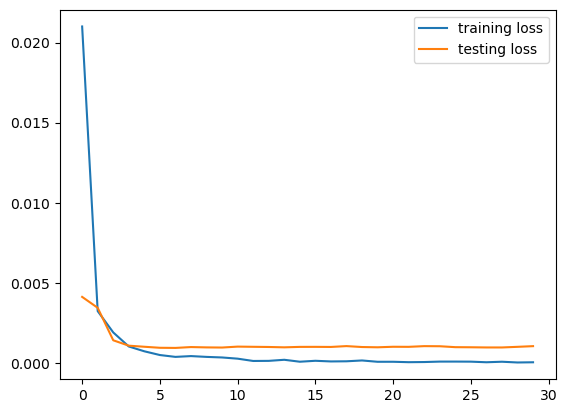

In [43]:
plt.plot(train_loss, label="training loss")
plt.plot(test_loss, label="testing loss")
plt.legend()

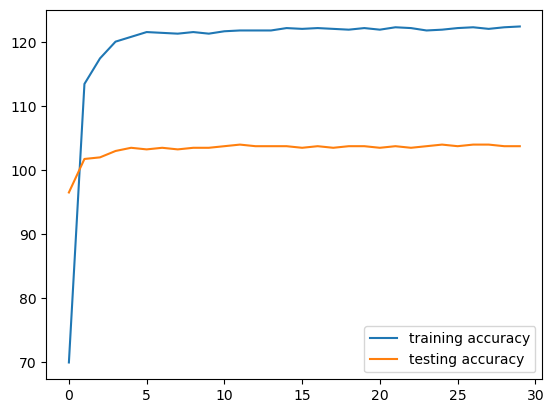

In [44]:
plt.plot(train_acc, label="training accuracy")
plt.plot(test_acc, label="testing accuracy")
plt.legend()

The training phase went very smoothly as the model achieves high accuracy very quickly and very likely overfits. The training error is smaller that the testing error and the training accuracy is higher then the testing accuracy. But I can say that the model is overall very accurate.

### Trying out the model

In [45]:
t = pd.DataFrame(feelings)
t["encoding"] = encoder.transform(t["feeling"].values)
t = t.drop_duplicates('feeling')
t

,index,feeling,encoding
0,C:\Users\imane\Downloads\archive (14)\Emotiona...,angry,0
199,C:\Users\imane\Downloads\archive (14)\Emotiona...,disgust,1
399,C:\Users\imane\Downloads\archive (14)\Emotiona...,fear,2
599,C:\Users\imane\Downloads\archive (14)\Emotiona...,happy,3
799,C:\Users\imane\Downloads\archive (14)\Emotiona...,neutral,4
999,C:\Users\imane\Downloads\archive (14)\Emotiona...,pleasant,5
1199,C:\Users\imane\Downloads\archive (14)\Emotiona...,sad,6


In [69]:
outputs = []
labels = []
with torch.no_grad():
    for a, l in test_loader:
        output = classifier(a)
        outputs.append(output)
        labels.append(l)

In [70]:
labels[0][0]

tensor(3)

In [71]:
torch.exp(outputs[0][0])

tensor([3.5909e-07, 1.7673e-06, 2.3770e-07, 1.0000e+00, 4.4827e-09, 1.4643e-06,
        4.1294e-09])

In [73]:
labels[0][8]

tensor(4)

In [74]:
torch.exp(outputs[0][8])

tensor([9.4216e-11, 2.9973e-11, 3.5472e-10, 3.7877e-09, 9.9999e-01, 6.2029e-06,
        1.7797e-09])

In [78]:
labels[0][3]

tensor(2)

In [79]:
torch.exp(outputs[0][3])

tensor([5.7261e-11, 1.2139e-11, 1.0000e+00, 3.9381e-06, 8.3699e-11, 2.6466e-10,
        5.8718e-08])

I first created a dataset that shows the label of each emotion, then I tested on three exmaples the actual labels and the output of the model. The output of the model is 7 probabilities of the instance being in a class, and I can see that my classifier does correct inference.

### Conclusion

In this notebook I had the chance to experiment with audio data classification. I had to process the data to transform it from its original form to a form that neural network can learn from with the help of Fourier Transform. Then I fed the data to a simple linear neural net which can accurately predict the emotion from the audio.